In [364]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [365]:
import sys
sys.path.insert(0, '..')

In [366]:

import glob
import math

import seaborn
import pandas
from matplotlib import pyplot as plt

from src.experiments.analyze import enrich_results, plot_size_improvement, name_strategies


In [367]:
def read_parquet(pattern, **kwargs):
    frames = []
    for file in glob.glob(pattern):
        part = pandas.read_parquet(file, **kwargs)
        frames.append(part)

    df = pandas.concat(frames)
    return df
    

In [450]:
ref = read_parquet('../output/results/trees_min_samples_leaf_2/*sklearn*')
ref['min_samples_leaf'] = 1
ref['trees'] = 100
hyper = read_parquet('../output/results/max_depth/*trees*')
hyper['trees'] = hyper.n_estimators
data = pandas.concat([ref, hyper], ignore_index=True)
data = enrich_results(data)
#data['total_size_kb'] = data.total_size / 1000
data['leaf_size_percent'] = 100.0 * (data['leaf_size'] / data['total_size'])
data['unique_leaves_percent'] = 100.0 * (data['test_uniqueleaves'] / data['test_leaves'])
data = data[~data.dataset.isin(['1510'])]
data.head(5)

,leaves_per_class,leaf_bits,split,test_nodes,test_leaves,test_leafsize,test_uniqueleaves,test_roc_auc,dataset,experiment,...,n_estimators,max_depth,dtype,folds,repetitions,leaf_size,decision_size,total_size,leaf_size_percent,unique_leaves_percent
id,,,,,,,,,,,,,,,,,,,,,
947c08fb-bd59-4441-8759-c0bf88d8d507,NaN,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042
862fe123-cb5c-48c5-a37a-74170bdee72c,1.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042
82e85397-c701-4ecc-a021-2be7b9ef3616,2.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042
6cd61d84-499d-4a4e-909a-c3c2958f8b09,4.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042
33604737-6b96-47bc-a0c5-c692f3655c84,8.0,NaN,0,5092,2596,2.0,2,100.0,1462,sklearn_defaults,...,NaN,NaN,NaN,NaN,NaN,16.0,19968,19984.0,0.080064,0.077042


In [451]:

def compute_perf_change(df, groupby='dataset', metric='test_roc_auc'):
    df = df.copy()

    ref_df = df[df.experiment == 'sklearn_defaults'].reset_index().groupby('dataset').median(numeric_only=True)

    print(sorted(ref_df.index))
    
    # Extract change in performance
    def subtract_ref(df, metric='test_roc_auc'):
        dataset = df.name
        matches = ref_df.loc[dataset]
        #assert len(matches) == 1, matches
        ref = matches[metric]
        out = df[metric] - ref
        return out

    def divide_ref(df, metric='test_roc_auc'):
        dataset = df.name
        matches = ref_df.loc[dataset]
        #assert len(matches) == 1, matches
        ref = matches[metric]
        out = df[metric] / ref
        return out

    grouped = df.groupby('dataset', as_index=False)
    df['perf_change'] = grouped.apply(subtract_ref, include_groups=False).reset_index().set_index('id')[metric]
    df['size_change'] = grouped.apply(divide_ref, metric='total_size', include_groups=False).reset_index().set_index('id')['total_size']

    return df

from src.experiments.analyze import name_strategies

unoptimized = name_strategies(data)
unoptimized = unoptimized[unoptimized.strategy.isin(['majority', 'original', 'joint'])]
unoptimized.loc[(unoptimized.experiment == 'sklearn_defaults') & (unoptimized.strategy != 'original')] = None
unoptimized.loc[(unoptimized.strategy == 'joint') & (unoptimized.leaf_bits != 8) & (unoptimized.leaves_per_class != 8), 'strategy'] = None
unoptimized = unoptimized.dropna(subset=['strategy'])
#print(unoptimized[unoptimized.experiment == 'sklearn_defaults']['strategy'].value_counts())
print(unoptimized.experiment.value_counts())
print(unoptimized.strategy.value_counts())
unoptimized = compute_perf_change(unoptimized, groupby=['dataset'])
unoptimized.head(1)

#unoptimized.experiment.value_counts()

experiment
trees_max_depth-5-10     2805
trees_max_depth-10-4     2805
trees_max_depth-20-10    2805
trees_max_depth-40-8     2805
trees_max_depth-10-10    2805
trees_max_depth-20-16    2805
trees_max_depth-5-16     2805
trees_max_depth-5-8      2805
trees_max_depth-5-6      2805
trees_max_depth-5-4      2805
trees_max_depth-10-20    2805
trees_max_depth-20-20    2805
trees_max_depth-10-14    2805
trees_max_depth-5-2      2805
trees_max_depth-40-2     2805
trees_max_depth-40-18    2805
trees_max_depth-20-6     2805
trees_max_depth-5-18     2805
trees_max_depth-20-2     2805
trees_max_depth-20-8     2805
trees_max_depth-5-14     2805
trees_max_depth-40-10    2805
trees_max_depth-40-16    2805
trees_max_depth-10-16    2805
trees_max_depth-20-4     2805
trees_max_depth-10-2     2805
trees_max_depth-20-18    2805
trees_max_depth-10-8     2805
trees_max_depth-40-20    2805
trees_max_depth-10-12    2805
trees_max_depth-10-6     2805
trees_max_depth-10-18    2805
trees_max_depth-40-12    2805

,leaves_per_class,leaf_bits,split,test_nodes,test_leaves,test_leafsize,test_uniqueleaves,test_roc_auc,dataset,experiment,...,folds,repetitions,leaf_size,decision_size,total_size,leaf_size_percent,unique_leaves_percent,strategy,perf_change,size_change
id,,,,,,,,,,,,,,,,,,,,,
947c08fb-bd59-4441-8759-c0bf88d8d507,NaN,NaN,0.0,5092.0,2596.0,2.0,2.0,100.0,1462,sklearn_defaults,...,NaN,NaN,16.0,19968.0,19984.0,0.080064,0.077042,original,0.010785,1.004019


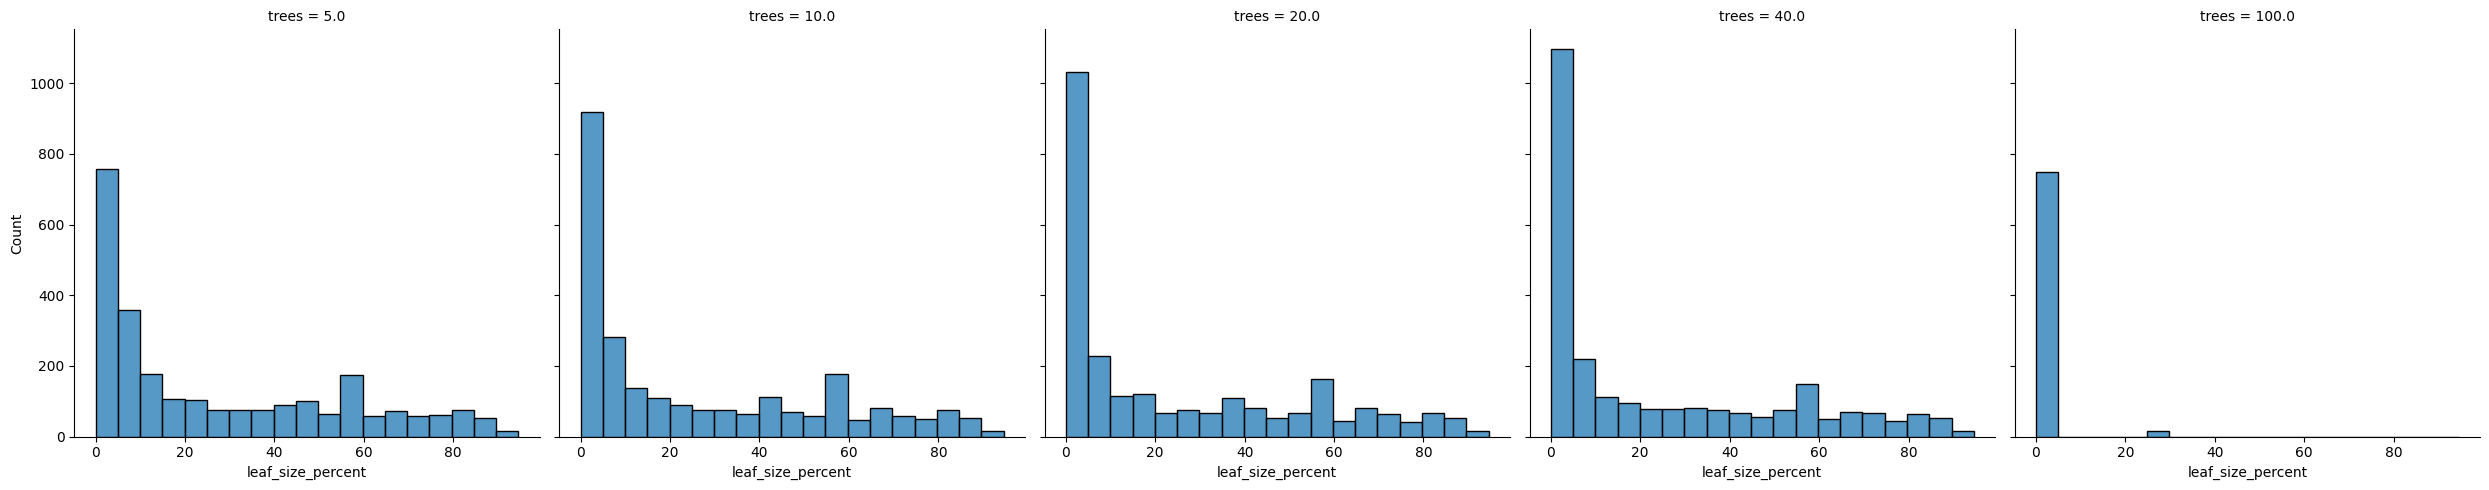

In [452]:
seaborn.displot(data=unoptimized[unoptimized.strategy == 'original'], col='trees', kind='hist', x='leaf_size_percent', binwidth=5)

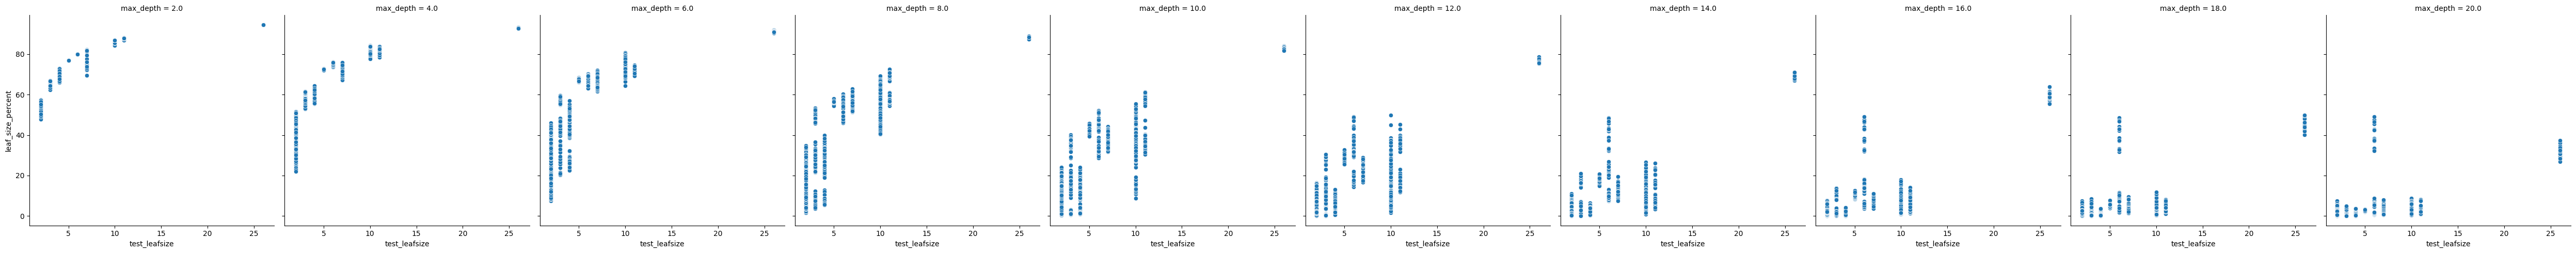

In [455]:
#depth_limit = 'min_samples_leaf'
depth_limit = 'max_depth'
seaborn.relplot(data=unoptimized[unoptimized.strategy == 'original'], col=depth_limit, kind='scatter', x='test_leafsize', y='leaf_size_percent')


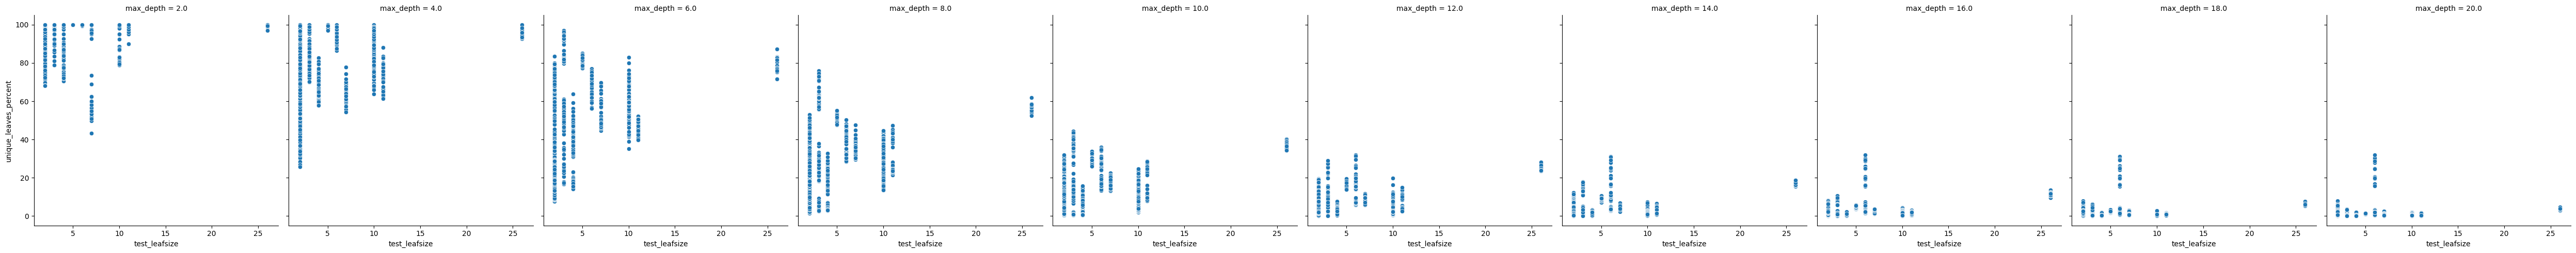

In [456]:

seaborn.relplot(data=unoptimized[unoptimized.strategy == 'original'], col=depth_limit, kind='scatter', x='test_leafsize', y='unique_leaves_percent')





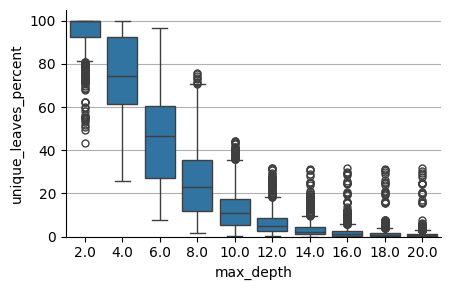

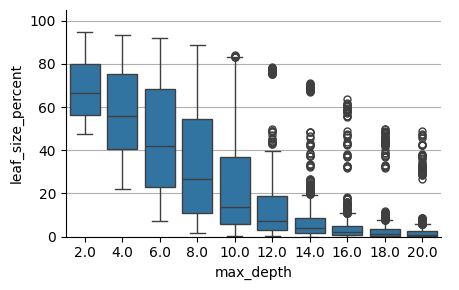

In [457]:

def add_grid(g, **kwargs):
    for i, ax in enumerate(g.axes.flatten()):
        ax.grid(**kwargs)


sel = unoptimized[(unoptimized.strategy == 'original')]
unoptimized[(unoptimized.strategy == 'original') & (unoptimized.trees == 10)]

#fig, axs = plt.subplots(ncols=2)
height = 3.0
aspect = 1.5
g = seaborn.catplot(data=sel,
                x=depth_limit, kind='box', y='unique_leaves_percent', 
                height=height, aspect=aspect)
g.set(ylim=(0, 105))
add_grid(g, axis='y')
g.figure.tight_layout()
g.figure.savefig('leaf-uniqueness.png')

g = seaborn.catplot(data=sel,
                x=depth_limit, kind='box', y='leaf_size_percent', 
                height=height, aspect=aspect,)
g.set(ylim=(0, 105))
add_grid(g, axis='y')
g.figure.tight_layout()
g.figure.savefig('leaf-proportion.png')



In [458]:
reduced = unoptimized.copy()
reduced = reduced[~reduced.experiment.isin(['sklearn_defaults'])]
reduced.shape

(112200, 27)

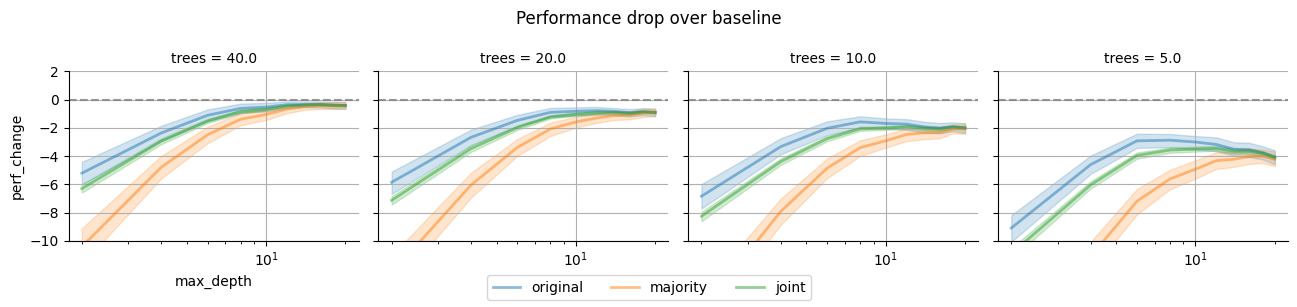

In [460]:


col_order = sorted(reduced.trees.unique(), reverse=True)
g = seaborn.relplot(data=reduced.reset_index(),
                    kind='line',
                    x=depth_limit,
                    y='perf_change',
                    hue='strategy',
                    col='trees',
                    col_order=col_order,
                    aspect=1, height=3,
                    legend=True,
                    #errorbar=None,
                    #err_style='bars',
                    lw=2.0,
                    alpha=0.5,
                   )
g.set(xscale="log")
#g.set(xlim=(1, 100))
g.set(ylim=(-10, 2))
g.refline(y=0.0, alpha=0.8, ls='--')
#g.refline(y=-2.0, alpha=0.5, color='black')
#g.refline(y=-4.0, alpha=0.5, color='orange')
for i, ax in enumerate(g.axes.flatten()):
    ax.grid()
    if i >= 1:
        x_axis = ax.axes.get_xaxis()
        x_axis.get_label().set_visible(False)


g.figure.suptitle('Performance drop over baseline')
g.figure.tight_layout()
g.figure.legends = []
g.figure.legend(loc="lower center", ncol=3)
g.figure.savefig('hyperparam-perfdrop-trees-strategies.png')


In [ ]:

g = seaborn.relplot(data=reduced.reset_index(),
                    kind='line',
                    x='min_samples_leaf',
                    y='total_size',
                    hue='strategy',
                    row='trees',
                    aspect=2, height=5,
                    legend=True,
                    #errorbar=None,
                    #err_style='bars',
                    lw=2.0,
                    alpha=0.5,
                   )
g.set(xscale="log")
for ax in g.axes.flatten():
    ax.grid()


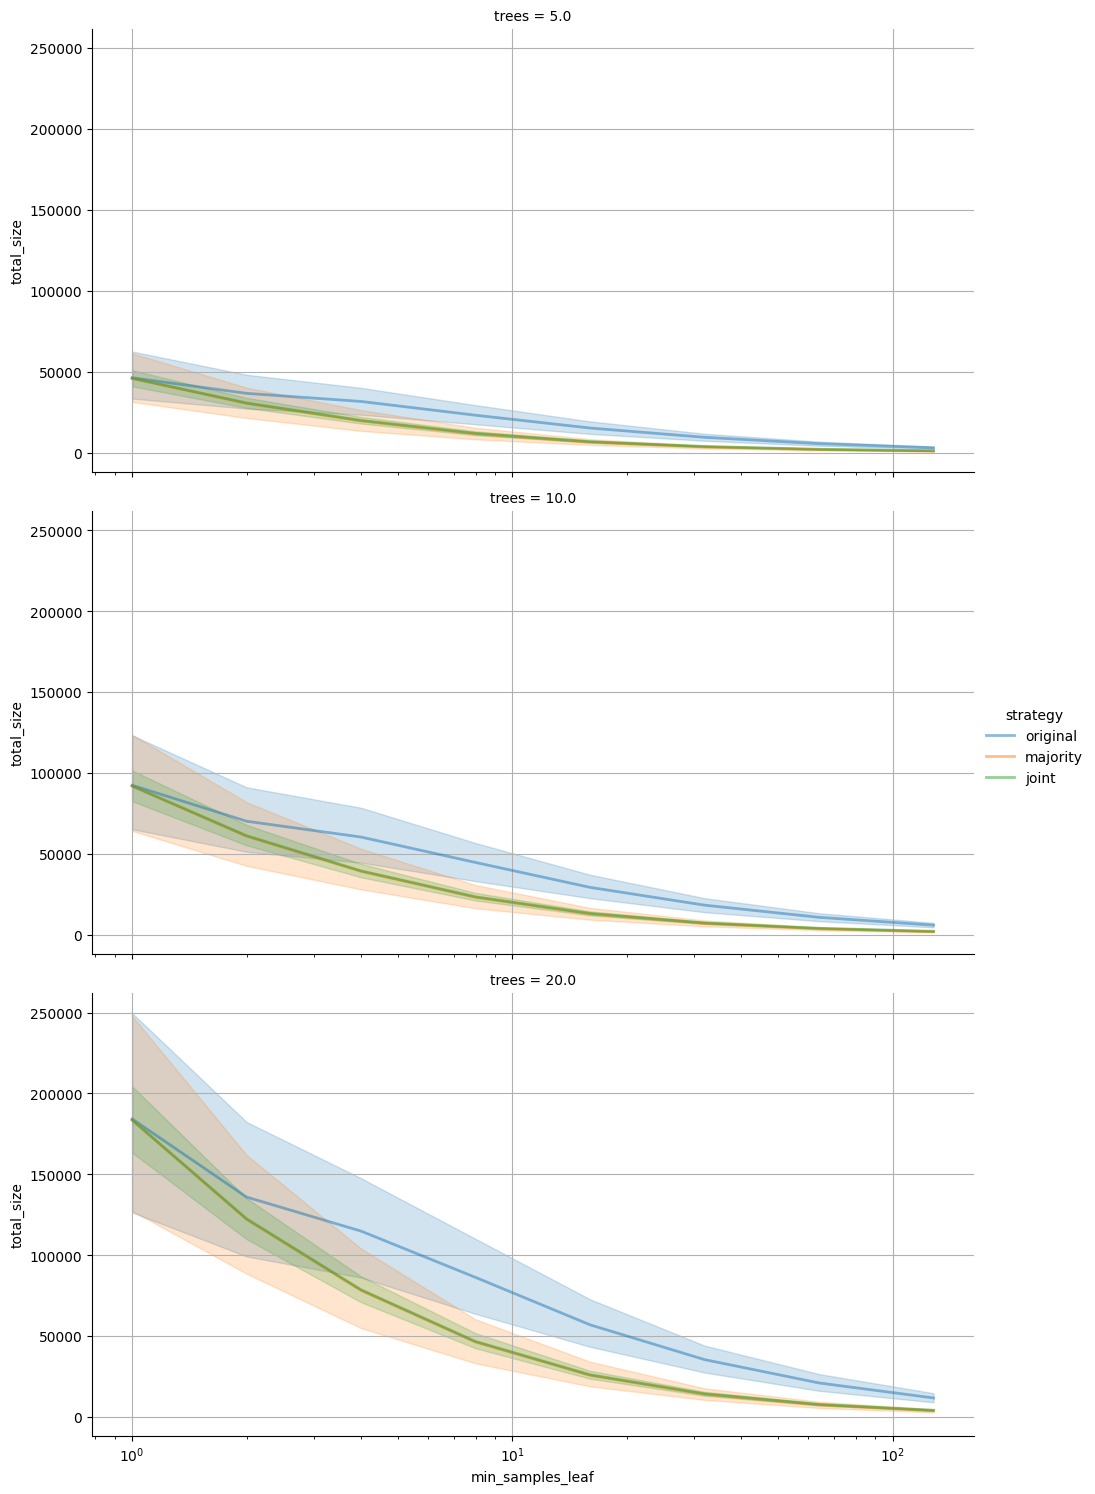

In [362]:
g = seaborn.relplot(data=reduced.reset_index(),
                    kind='line',
                    x='min_samples_leaf',
                    y='total_size',
                    hue='strategy',
                    row='trees',
                    aspect=2, height=5,
                    legend=True,
                    #errorbar=None,
                    #err_style='bars',
                    lw=2.0,
                    alpha=0.5,
                   )
g.set(xscale="log")
for ax in g.axes.flatten():
    ax.grid()


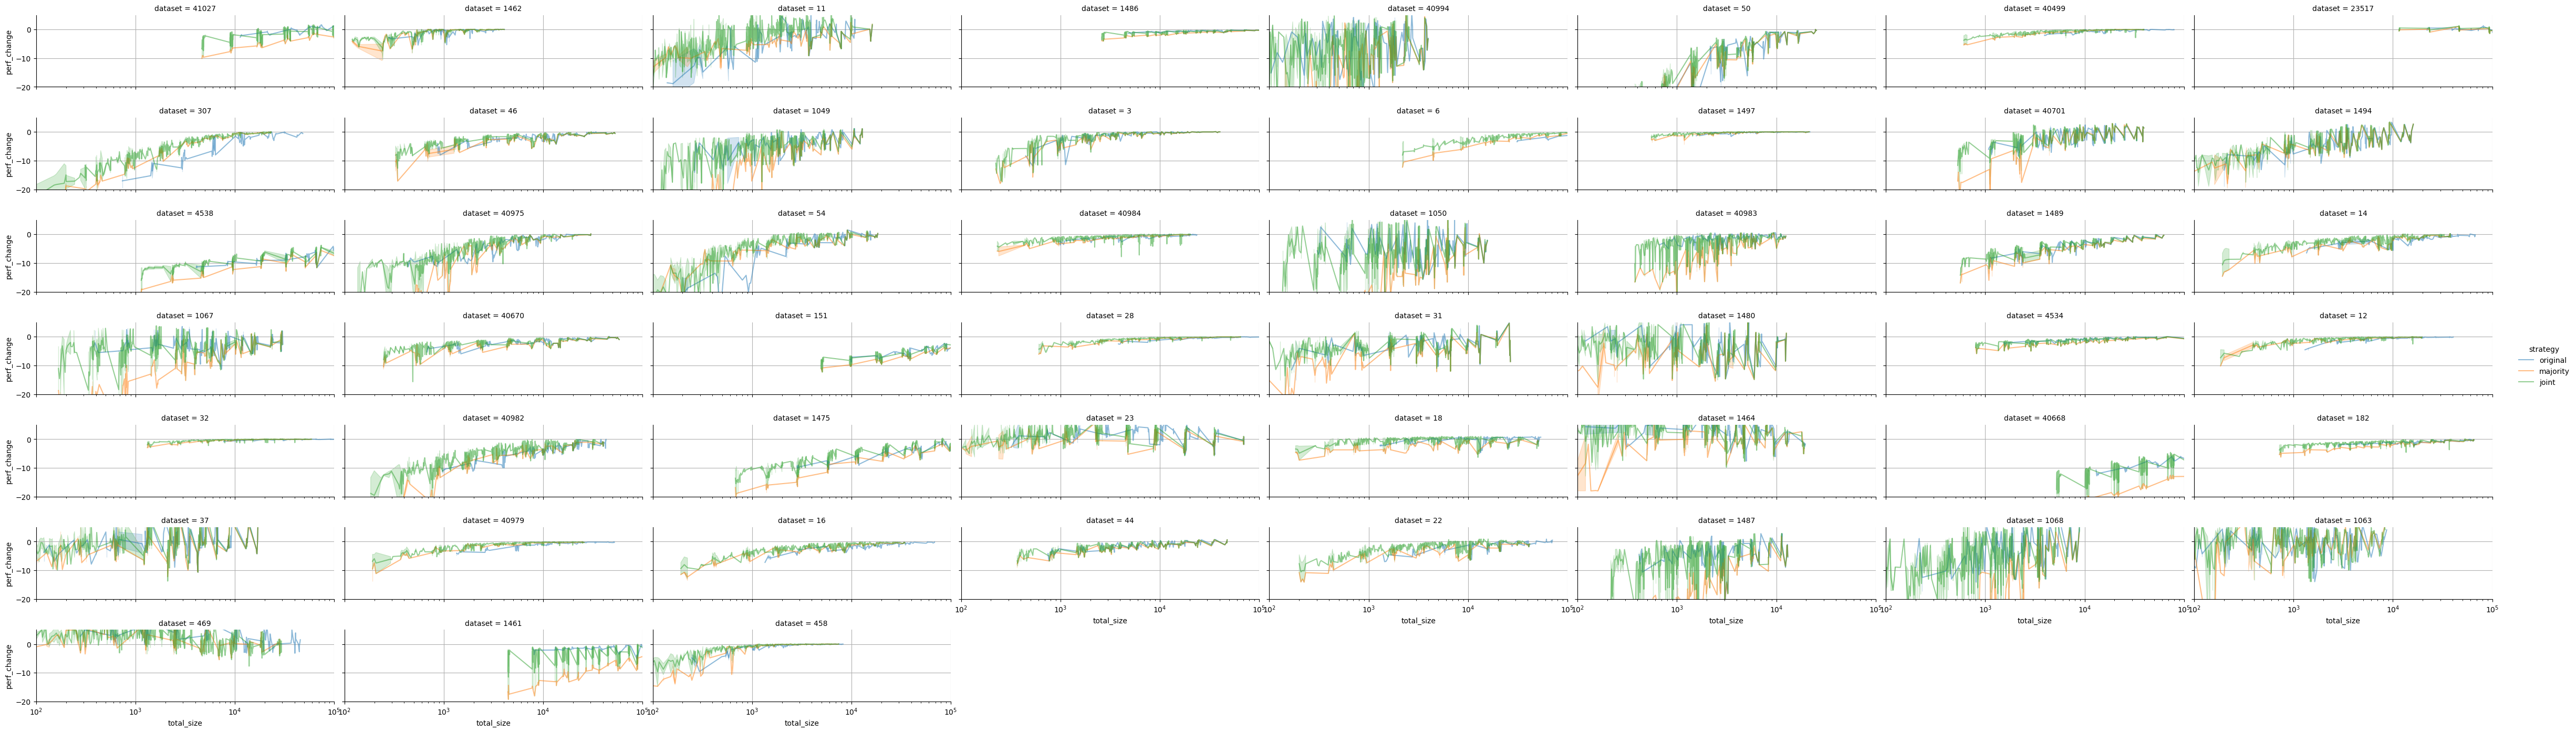

In [363]:
g = seaborn.relplot(data=reduced.reset_index(),
                    kind='line',
                    x='total_size',
                    y='perf_change',
                    hue='strategy',
                    col='dataset',
                    col_wrap=8,
                    aspect=3, height=2,
                    legend=True,
                    #errorbar=None,
                    #err_style='bars',
                    #lw=2.0,
                    #s=10.0,
                    alpha=0.5,
                   )
g.set(xscale="log")
g.set(ylim=(-20, 5))
g.set(xlim=(100, 100e3))
for ax in g.axes.flatten():
    ax.grid()  

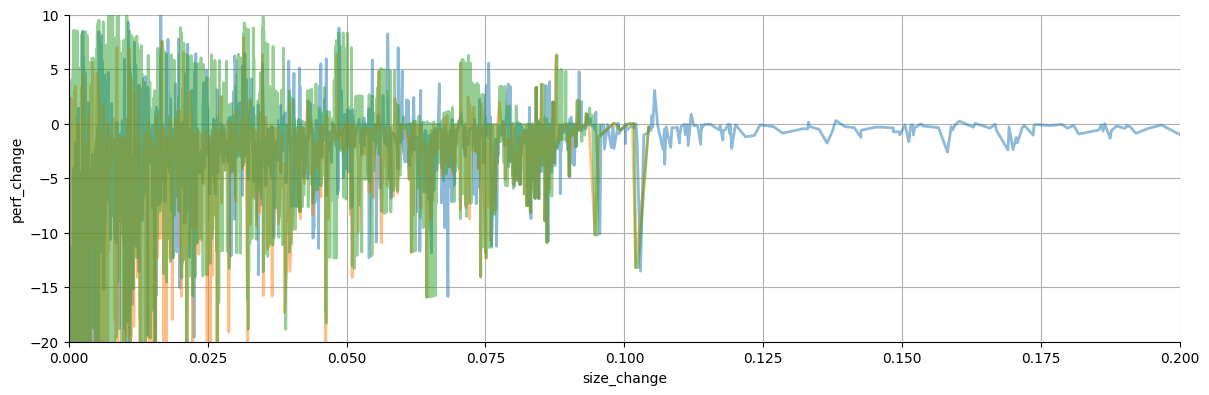

In [319]:
g = seaborn.relplot(data=reduced.reset_index(),
                    kind='line',
                    x='size_change',
                    y='perf_change',
                    hue='strategy',
                    #col='strategy',
                    #col_wrap=8,
                    aspect=3, height=4,
                    legend=False,
                    errorbar=None,
                    #err_style='bars',
                    lw=2.0,
                    alpha=0.5,
                   )
#g.set(xscale="log")
g.set(ylim=(-20, 10))
g.set(xlim=(0.0, 0.20))
for ax in g.axes.flatten():
    ax.grid()  

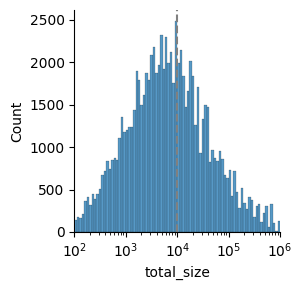

In [401]:
g = seaborn.displot(data=unoptimized.reset_index(), x='total_size', binrange=(0, 6), log_scale=True, height=3)
g.refline(x=10e3)
g.set(xlim=(100, 1e6))

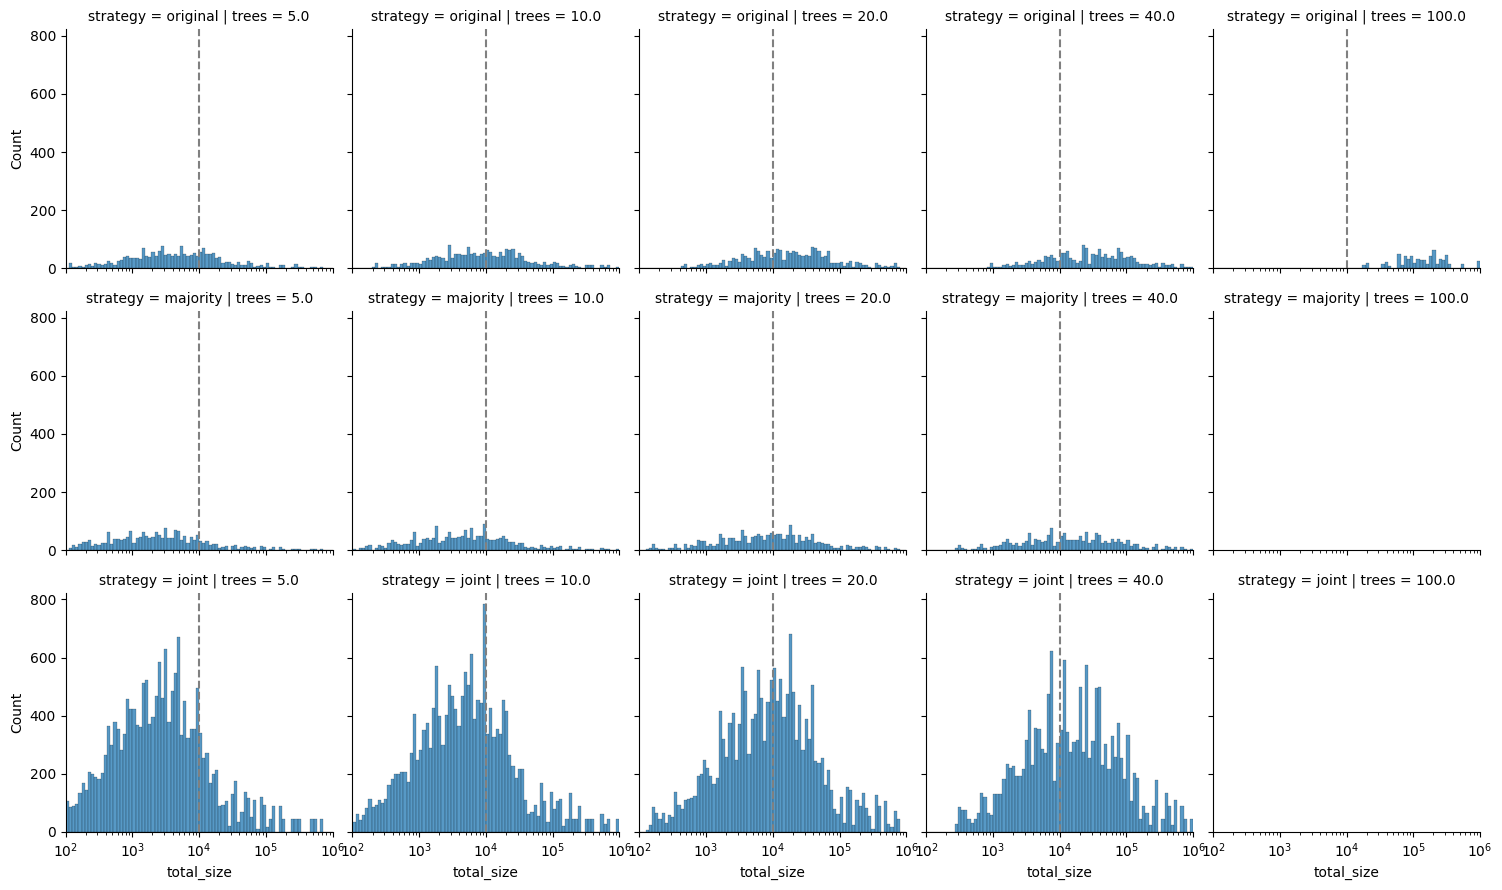

In [403]:
g = seaborn.displot(data=unoptimized.reset_index(), x='total_size', binrange=(0, 6), log_scale=True, col='trees', row='strategy', height=3)
g.refline(x=10e3)
g.set(xlim=(100, 1e6))